## Image Segmentation using Graph Theory

This notebook implements a binary segmentation method based on graph theory. The idea is to write down the segmentation problem as a graph problem. First we build a graph G whose nodes are pixels of the image we want to segment in addition to two nodes representing the background and the foreground of the image.

In [79]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from PIL import Image
np.random.seed(7)

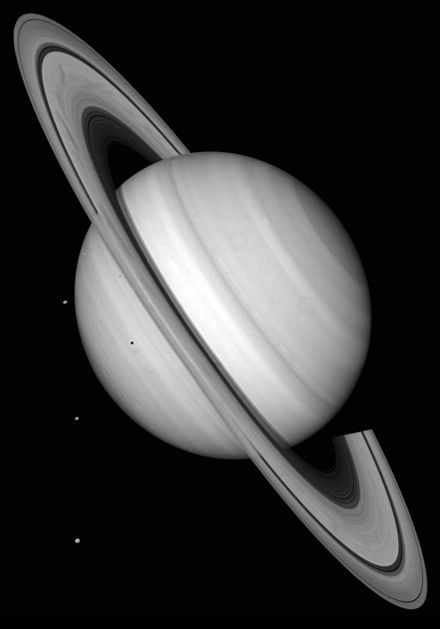

In [88]:
# This is the image we would like to segment, so we want to find the contour of planet ...
im = Image.open("./images/saturn.jpg")
im